# Navigation Double DQN-Dueling

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# !pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

## Additional Package
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# please do not modify the line below
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# env_info = env.reset(train_mode=True)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

# Building a Dueling Networks
#### Dueling
Actor(policy) Model: 
* input_size = state_size
* output_size = action_size
Hidden layers [fc1, fc2]

Dueling:
* Estimates the state value function
* Estimates the advantage for each action
* Combine the state and advantage values to get Q-values

State values: V(s)

Advantage values: A(s,a)

Q-values = Q(s,a) = V(s) + A(s,a)

In [7]:
# Necessary Packages
import torch
import torch.nn as nn
import torch.nn.functional as F

#Build model
# Dueling
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=32):
        '''
        Builds a feedforward nework with two hidden layers
        Initialize parameters
        
        Params
        =========
        state_size (int): Dimension of each state (input_size)
        action_size (int): dimension of each action (output_size)
        seed (int): Random seed(using 0)
        fc1_units (int): Size of the first hidden layer
        fc2_units (int): Size of the second hidden layer
        '''
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Add the first laer, input to hidden layer
        self.fc1 = nn.Linear(state_size, fc1_units)
        # Add more hidden layer
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # State-value V
        self.V = nn.Linear(fc2_units, 1)
        
        # Advantage function A
        self.A = nn.Linear(fc2_units, action_size)
        
        
    def forward(self, state):
        """
        Forward pass through the network. Build a network that mps state -> action values.
        
        return Q function
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        V = self.V(x)
        A = self.A(x)
        
        return V + (A - A.mean(dim=1, keepdim=True))
    

# Experience Replay
Replay buffer: It conains a collection of experience tuples (S,A,R,S'). The tuples are gradually added to the buffer as we are interacting with the environment. The purpose of using replay buffer is to prevent high correlation from the sequence of experience tuples while agent interacts with the environment.

<S,A,R,S'> --learn-->  Agent     <=>    Environment

Highly correlated.



<S,A,R,S'> --store as memory-->  ReplayBuffer --sample-->  Agent     <=>    Environment

It helps break the correlation and ultimately prevents

We want to equally update value function




In [8]:
# Necessary Packages
import numpy as np
import random
from collections import namedtuple, deque

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """
        Only stores the last N experience tuples in the replay memory
        
        Params
        ======
            action_size (int): Dimension of each action (output_size)
            buffer_size (int): Maximum size of buffer
            batch_size (int): Size of each training batch
            seed (int): Random seed
        """
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)                                # initialize replay memory D with capacity N
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])       # initialize acollection of experience tuple
        self.seed = random.seed(seed)
        self.device = device
        
    def add(self, state, action, reward, next_state, done):
        """
        Store the agent's experiences to the memory at eatch time-step.
        e_t = (s_t, a_t, r_t, s_(t+1))
        """
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """
        Samples uniformly at random from D(D_t = {e_1, ..., e_t}) when performing update
        This is where we prevent correlation
        """
        
        # D
        experiences = random.sample(self.memory, k=self.batch_size)
        # Store in
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        # return D
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        '''
        Return the current size of internal memory
        '''
        return len(self.memory)
        

# Implement Agent
* Agent(state_size=37, action_size=4, seed=0)

The standard Q-learning update for the parameter after taking action A_t in state S_t and observing the immediate reward R_(t+1) and resulting state S_(t+1) is:
* γ: gamma
* θ_t: weights
* R_(t+1): immediate reward
* S_(t+1): next state(resulting state)
* Q: Q-alue

TD target = R_(t+1) + γmaxQ(S_(t+1), a; θ-_t)


θ_(t+1) = θ_t + α(TD target - Q(S_t, A_t; θ_t))∇_(Q_t)Q(S_t, A_t; Q_t)

### DQN

* θ-_t: θ-_t is the same as the online network except that its parameters are copied every t steps from the online network that its parameters are copied every t steps from the online network, so that then θ-_t = θ_t, and kept fixed on all other steps.

TD target = R_(t+1) + γmaxQ(S_(t+1), a; θ-_t)

### DDQN
Expand the max operation from TD target in DQN

* θ_t: Second set of weights (select best action
* argmaxQ: action with max Q-value
* θ'_t: evaluate that action

TD target = R_(t+1) + γQ(S_(t+1), argmaxQ(S_(t+1), a; θ_t); θ'_t)

This θ'_t can be updated symmetrically by switching the toles of θ_t and θ'_t


In [9]:
# Necessary Packages
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

# Hyperparameters
LR = 5e-4                # learning rate
BUFFER_SIZE = int(1e5)   # replay buffer size N
BATCH_SIZE = 64          # minibatch size
UPDATE_EVERY = 4         # how often to update the network
GAMMA = 0.99             # Discount factor
TAU = 1e-3               # for soft update of target parameters


# Setup Gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Builed Agent(): Evaluate ddqn agent on unmodified game
class Agent():
    def __init__(self, state_size, action_size, seed):
        """
        Setup Agent object
        Implement DDQN parameter updates
        
        Params
        ======
            state_size (int): Dimension of each state (input_size)
            action_size (int): Dimension of each action (output_size)
            seed (int): Random seed
        
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network: Neural network function approximate with weights theta θ as a Q-Network.
        # A Q-Network can be trained by adjusting the parameters θ_i at iteration i to reduce the mse in the Bellman equation
        # The outputs correspond to the predicted Q-values of the individual action for input state
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        # specify optimizer(Adam)
        # optim.Adam(Qnet.parameters(), small learning rate)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) ###
        
        # First, use a technique known as experience replay in which we stre the agent's experience at each time-step,
        # e_t= (s_t, a_t, r_t, s_(t_1)), in a data set D_t ={e_1,...,e_t},pooled over many episodes(where the end of an episode occurs when
        # a terminal state is reached) into a replay memory.
        #Initialize replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, device) ###
        self.t_step = 0                                                 # Initialize time step (update every UPDATE_EVERY steps)
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)        # save experience in replay memory
        
        # Learn every UPDATE_EVERY time steps
        self.t_step =(self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # if enough samples are availabe in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE: ###
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA) ###
                
    def act(self, state, eps=0):
        '''
        Choose action A from state S using policy pi <- epsilon-Greedt(q^hat (S,A,w))
        Return actions for given state as per current policy.
        
        Params
        ======
            state (array_like): Current state
            eps (float): Epsilon, for epsilon-greedy action selection        
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # It is off-policy: it learns about the greedy policy a = argmax Q(s,a';θ),
        # while following a behaviour distribution is often selected by an eps-greedy policy
        # that follows the greey policy with probability 1-eps and selects a random action
        # with probability eps.
        # Epsilon-greedy action selection
        # with probability epsilon select a random action a_t
        # otherwise select a_t = argmax_a Q (phi(s_t),a; θ)
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    #DDQN
    def learn(self, experiences, gamma): # only use the local and target Q-networks to compute the loss before taking a step towards minimizing the loss
        '''
        Update value parameters using given batch of experience tuples
        Use DDQN methods
        
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        
        '''
        states, actions, rewards, next_states, dones = experiences
        #### Double DQN
        self.qnetwork_local.eval()
        with torch.no_grad():
            Q_pred = self.qnetwork_local(next_states)                      
            max_actions = torch.argmax(Q_pred, dim=1).long().unsqueeze(1)  # # Fetch max action arguemnt to pass
            Q_next = self.qnetwork_target(next_states)                     # Q_targets over next statesfrom actions will be taken based on Q_pred's max_action
        self.qnetwork_local.train()
        Q_targets = rewards + (gamma * Q_next.gather(1, max_actions) * (1.0 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)        # Get expected Q values from local model


        loss = F.mse_loss(Q_expected, Q_targets)                           # calculate the loss        
        self.optimizer.zero_grad()                                         # zero the parameter (weight) gradients
        loss.backward()                                                    # backward pass to calculate the parameter gradients
        self.optimizer.step()                                              # update the parameters
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)   ###,#Update target network
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
        
        
        
        
        
        

# Train the DDQN Agent
### Train Double Deep Q-Learning with

* maximum number of training episodes: 2000
* maximum number of timesteps per episode: 1000
* starting value of epsilon for epsilon-greedy action selection: 1.0
* minimum value of epsilon: 0.01
* multiplacative factor (per episode for decreasing epsilon: 0.995

Episode 100	 Average Score:0.633
Episode 200	 Average Score:4.277
Episode 300	 Average Score:7.577
Episode 400	 Average Score:9.999
Episode 500	 Average Score:12.733
Episode 565	 Average Score: 14.02
Environment solved in 465 episodes!	Average Score: 14.02


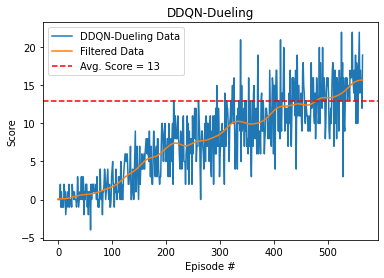

In [10]:
# Setting the environment
agent = Agent(state_size=37, action_size=4, seed=0)

from collections import deque
import numpy as np
import torch

def dqn(n_episodes = 2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Train the Agent with Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                                                 # Initialize collecting scores from each episode
    scores_window = deque(maxlen=100)                           # Initialize collecting maxlen(100) scores
    eps = eps_start                                             # initialize starting value of epsilon
    
    # for each episode
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # begin the episode
        state = env_info.vector_observations[0]  
        score = 0                                               # initialize the sampled score(reward)
        
        # Set constrain maximum number of time step per episode
        for t in range(max_t):
            action = agent.act(state, eps)                      # agent select an action
            env_info = env.step(action)[brain_name]             # send the action to the environment
            
            # agent performs the selected action
            #next_state, reward, done, _ = env.step(action)
            next_state = env_info.vector_observations[0]        # get the next state
            reward = env_info.rewards[0]                        # get the reward
            done = env_info.local_done[0]                       # see if episode has finished
    
            agent.step(state, action, reward, next_state, done) # agent performs internal updates based on sampled experience
            # update the sampled reward
            score += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                break
        scores_window.append(score)                              # Save most recent score
        scores.append(score)                                     # Save most recent score
        eps = max(eps_end, eps_decay*eps)                        # Decrease epsilon
        
        # monitor progress
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # get average reward from last 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\t Average Score:{:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=14.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            # save model
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()


# plot the scores
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(scores, sigma=12)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDQN-Dueling Data')
plt.plot(np.arange(len(scores)), ysmoothed, label='Filtered Data')
plt.title("DDQN-Dueling")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axhline(y=13, color='r', linestyle='--', label='Avg. Score = 13')
plt.legend(loc='best')
plt.savefig('DDQN-Dueling.png')
plt.savefig('DDQN-Dueling.pdf')
plt.show()

In [11]:
print("Environment solved in 525 episodes!	Average Score: 14.01")

Environment solved in 525 episodes!	Average Score: 14.01


# Run Environment

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

import time
time.sleep(5)
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.int16(agent.act(state)).item()     # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    time.sleep(0.05)
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 19.0


In [13]:
env.close()